![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Data-driven distributionally robust optimization ([Mohajerin Esfahani and Kuhn, 2018](https://rdcu.be/cbBoC))

This notebook illustrates <i>parameterization</i> in MOSEK's [Fusion API for python](https://docs.mosek.com/9.2/pythonfusion/intro_info.html), by implementing the numerical experiments presented in a paper titled <i> "Data-driven distributionally robust optimization using the Wasserstein metric: performance guarantees and tractable reformulations"</i> ([Mohajerin Esfahani and Kuhn](https://rdcu.be/cbBoC) hereafter), authored by [Peyman Mohajerin Esfahani](https://scholar.google.co.in/citations?user=ZTan-7YAAAAJ&hl=en) and [Daniel Kuhn](https://scholar.google.com/citations?user=RqnXytkAAAAJ&hl=en). 

#### Contents:
1. [Data-driven stochastic programming (Paper summary)](#Data-driven-stochastic-programming-(Paper-summary))  
   - [Choice of the ambiguity set](#Choice-of-the-ambiguity-set-$\widehat{\mathcal{P}}_N$)
   - [Convex reduction of the worst-case expectation problem](#Convex-reduction-of-the-worst-case-expectation-problem)


2. [Mean risk portfolio optimization with Fusion API](#Mean-risk-Portfolio-Optimization-(Section-7.1-in-paper))  
   - [Parameterized Fusion model](#Parameterized-Fusion-model)
   - [Market setup](#Market-setup)


3. [Simulations and results](#Simulations-and-results)

   - [Impact of the Wasserstein radius](#Impact-of-the-Wasserstein-radius)
   - [Portflios driven by out-of-sample performance](#Portfolios-driven-by-out-of-sample-performance)
       - [Holdout method](#Holdout-method)
       - [k-fold cross validation method](#k-fold-cross-validation-method)
   - [Portfolios driven by reliability](#Portfolios-driven-by-reliability)
   - [Impact of sample size on Wasserstein radius](#Impact-of-sample-size-on-Wasserstein-radius)

# Data-driven stochastic programming (Paper summary)

Consider a loss function $h(x,\xi)$ which depends on the decision variables $x$ and uncertain parameters $\xi$. The goal is to minimize the <i>expected value</i> of $h(x,\xi)$ for all $x\in \mathbb{X}$, where $\mathbb{X} \subset \mathbb{R}^n$. The expected value is calculated over $\mathbb{P}(\xi)$, which is the probability distribution of the random vector $\xi \in \mathbb{R}^m$. This distribution is supported on the <i>uncertainty set</i> $\Xi$. The problem statement is written as in $\ref{eq:main_prob}$.

$$
\begin{equation}
J^\star := \underset{x\in \mathbb{X}}{\inf} \bigg\{ \mathbb{E}^{\mathbb{P}}\big[ h(x,\xi) \big] = \int_{\Xi} h(x,\xi)\mathbb{P}(d\xi)\bigg\}
\label{eq:main_prob} \tag{1}
\end{equation}
$$

In practice, however, the probability distribution is often unknown. Instead, one usually has access to a set $\widehat{\Xi}_N := \{\widehat{\xi}_i \}_{i\leq N}$, that contains $N$ historic realizations of the $\xi$ vector. A <i>data-driven</i> solution $\widehat{x}_N$ can be constructed by using some approximation of the true probability distribution. A natural choice for such an approximation is based on $\widehat{\Xi}_N$, and it is given by the <i>discrete empirical</i> probability distribution, as shown in $\ref{eq:empirical_dist}$.

$$
\begin{equation}
\mathbb{\widehat{P}}_N := \frac{1}{N}\sum^{N}_{i = 1} \delta_{\widehat{\xi}_i}
\label{eq:empirical_dist} \tag{2}
\end{equation}
$$

The <i>sample-average-approximation</i>, which is obtained by replacing $\mathbb{P}$ with $\mathbb{\widehat{P}}_N$ in $\ref{eq:main_prob}$, is usually easier to solve but shows poor <i>out-of-sample</i> performance. Out-of-sample performance of a data-driven solution $\widehat{x}_N$ is the expected loss for that decision under the <i>true</i> probability distribution. To obtain better out-of-sample performance, [Mohajerin Esfahani and Kuhn](https://rdcu.be/cbBoC) solve the robust optimization problem stated in $\ref{eq:dist_rob}$.

$$
\begin{equation}
\widehat{J}_N := \underset{x\in \mathbb{X}}{\inf} \underset{\mathbb{Q}\in \mathcal{\widehat{P}}_N}\sup \mathbb{E}^\mathbb{Q}\big[ h(x, \xi)\big]
\label{eq:dist_rob} \tag{3}
\end{equation}
$$

The <i><b> distributionally</b> robust</i> problem stated in $\ref{eq:dist_rob}$ is conceptually similar to $\ref{eq:main_prob}$, <i>but</i> it compensates for the unknown $\mathbb{P}$ by <i>maximizing</i> the expected value over all probability distributions $\mathbb{Q}$ inside an ambiguity set $\widehat{\mathcal{P}}_N$. Maximization is done in order to obtain the worst-case estimate.

If $\widehat{x}_N$ is an optimal decision vector for the distributionally robust program, then the authors associate performance guarantees to $\widehat{x}_N$ of the type shown in $\ref{eq:perf_guarantee}$.

$$
\begin{equation}
\mathbb{P}^N \bigg\{ \widehat{\Xi}_N : \mathbb{E}^\mathbb{P}\big[ h(\widehat{x}_N, \xi) \big] \leq \widehat{J}_N \bigg \} \geq 1 - \beta
\label{eq:perf_guarantee} \tag{4}
\end{equation}
$$

Here, $\mathbb{P}^N$ is a probability distribution that governs the realization of the set $\widehat{\Xi}_N$. The expression in $\ref{eq:perf_guarantee}$ states that $\widehat{J}_N$ provides an upper bound to the out-of-sample performance of $\widehat{x}_N$ with at least $1-\beta$ probability. Thus, $\widehat{J}_N$ is a <i>certificate</i> of out-of-sample performance and the probability on the left side is the <i>reliability</i> of this certificate.

### Choice of the ambiguity set $\widehat{\mathcal{P}}_N$

The ambiguity set resides within a space of probability distributions and is chosen to be a <i>ball</i> of radius $\epsilon$ centered at $\widehat{\mathbb{P}}_N$. The metric of choice is the [Wasserstein metric](http://nbviewer.jupyter.org/github/MOSEK/Tutorials/blob/master/wasserstein/wasserstein-bary.ipynb). Mathematically, the ambiguity set is defined as shown in $\ref{eq:wass_ball}$.

$$
\begin{equation}
\mathbb{B}_\epsilon(\mathbb{\widehat{P}}_N) := \big\{ \mathbb{Q} \in \mathcal{M}(\Xi) : d_W (\mathbb{\widehat{P}}_N, \mathbb{Q}) \leq \epsilon \big\}
\label{eq:wass_ball} \tag{5}
\end{equation}
$$

As proved in section 3 of the paper, solving $\ref{eq:dist_rob}$ with $\mathcal{\widehat{P}}_N$ set to $\mathbb{B}_\epsilon(\mathbb{\widehat{P}}_N)$ will provide <i>finite sample performance guarantees</i> of the type seen in $\ref{eq:perf_guarantee}$. Furthermore, given certain assumptions (see paper), as $N\to\infty$, the certificate $\widehat{J}_N$ approaches $J^\star$ (optimal value of $\ref{eq:main_prob}$) and the data-driven decision $\widehat{x}_N$ approaches the true optimal decision $x^\star$.

### Convex reduction of the worst-case expectation problem

The infinite dimensional maximization problem within $\ref{eq:dist_rob}$ can be reduced to a computationally tractable finite-dimensional convex program, given the following requirements are met:

1.) The uncertainty set $\Xi$ is convex and closed.

2.) The loss function is a point-wise maximum of more elementary functions, i.e. $l(\xi) := \underset{k\leq K}{\max} l_k(\xi)$, where $-l_k(\xi)$ are proper, convex, and lower semi-continuous for all $k\leq K$. <i>Note the suppression of the loss function's dependence on $x$</i>.

For problems that satisfy these requirements, the convex reduction is given in $\ref{eq:convex_red}$.
$$
\begin{align}
& \underset{\lambda, s_i, z_{ik}, \nu_{ik}}{\inf} & & \lambda \epsilon + \frac{1}{N}\sum_{i=1}^{N}s_i & \nonumber \\
& \text{s.t.} & &[-l_k]^*(z_{ik} - \nu_{ik}) + \sigma_{\Xi}(\nu_{ik}) - \langle z_{ik},\widehat{\xi}_i\rangle \leq s_i & & \forall i\leq N , \forall k\leq K \label{eq:convex_red} \tag{6}\ \\
& & &\|z_{ik}\|_* \leq \lambda & & \forall i\leq N, \forall k\leq K \nonumber \\
\end{align}
$$

where $[-l_k]^*$ denotes the conjugate of the negative $k^{\text{th}}$ component of the loss function, $\|z_{ik}\|_*$ is the dual norm corresponding to the norm used in defining the Wasserstein ball and $\sigma_\Xi$ is the support function for the uncertainty set.

# Mean risk Portfolio Optimization (Section 7.1 in paper)

Consider a market that forbids short-selling and has $m$ assets. Yearly returns of these assets are given by the random vector $\xi = [\xi_1, ..., \xi_m]^T$. The <i>percentage weights</i> (of the total capital) invested in each asset are given by the decision vector $x = [x_1, ..., x_m]^T$ where $x$ belongs to $\mathbb{X} = \{x \in \mathbb{R}_+^m : \sum^{m}_{i=1}x_i = 1\}$. We have to solve the problem stated in $\ref{eq:mean_risk_port}$.

$$
\begin{equation}
J^\star = \underset{x\in \mathbb{X}}{\inf} \big\{ \mathbb{E}^{\mathbb{P}}[-\langle x, \xi \rangle] + \rho \mathbb{P}\text{-CVaR}_\alpha \big(-\langle x, \xi\rangle\big)\big\}
\label{eq:mean_risk_port} \tag{7}
\end{equation}
$$

which amounts to minimizing a weighted sum of the expected value and the conditional value-at-risk (see also: [Fusion notebook on stochastic risk measures](https://nbviewer.jupyter.org/github/MOSEK/Tutorials/blob/master/stochastic-risk/stochastic-risk-measures.ipynb)) of the portfolio loss, $- \langle x, \xi \rangle$. Using the definition of conditional value-at-risk ([Optimization of conditional value-at-risk](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) by R. T. Rockafellar and S. Uryasev), $\ref{eq:mean_risk_port}$ can be written as a <i>maximum of $K=2$ affine loss functions</i> ($\ref{eq:cvar_prob}$).

$$
\begin{equation}
J^\star = \underset{x \in \mathbb{X}, \tau \in \mathbb{R}}{\inf} \mathbb{E}^{\mathbb{P}}\big[\underset{k\leq K}{\max} a_k \langle x, \xi \rangle + b_k \tau \big]
\label{eq:cvar_prob} \tag{8}
\end{equation}
$$
$$
\text{where}\,\, a =\big(-1, -1-\frac{\rho}{\alpha}\big)\, ,\,\, b =\big(\rho, \rho-\frac{\rho}{\alpha}\big) 
$$

If the uncertainty set is a polytope of the form $\Xi = \{ \xi \in \mathbb{R}^m : C\xi \leq d \}$, then the distributionally robust counterpart of the program in $\ref{eq:cvar_prob}$ will have a convex reduction as shown in $\ref{eq:convex_red_port}$. 

$$
\begin{align}
& \underset{x,\tau,\lambda,s_i, \gamma_{ik}}{\inf} & & \lambda \epsilon + \frac{1}{N}\sum^{N}_{i=1}s_i & \nonumber \\
&\text{s.t.} & & b_k \tau + a_k \langle x, \widehat{\xi}_i \rangle + \langle \gamma_{ik}, d - C\widehat{\xi}_i\rangle \leq s_i & \forall i\leq N, \forall k\leq K \label{eq:convex_red_port} \tag{9}\\
& & &\| C^T \gamma_{ik} - a_k x\|_* \leq \lambda & \forall i\leq N, \forall k\leq K &\nonumber \\
& & & \gamma_{ik} \geq 0 & \forall i \leq N, \forall k \leq K & \nonumber \\
& & & x \in \mathbb{X} & \nonumber \\
\end{align}
$$

### Parameterized Fusion model

Finally, we make a [Fusion](https://docs.mosek.com/9.2/pythonfusion/api-reference.html) model for the program in $\ref{eq:convex_red_port}$. The following code cell defines `DistributionallyRobustPortfolio`, a wrapper class  (around our fusion model) with some convenience methods. The key steps in the Fusion model implementation are (see `portfolio_model` method in class):

- `M = Model('DistRobust_m{0}_N{1}'.format(m, N))`: instantiate a Fusion `Model` object.


- `dat = M.parameter('TrainData', [N, m])` and `eps = M.parameter('WasRadius')`: declare a Fusion `parameter` object named "TrainData" and a parameter for the Wasserstein Radius, called "WasRadius". "TrainData" represents the past `N` realizations of the `m` sized random vector, $\xi$. 


- `a_k = [-1, -51]` and `b_k = [10, -40]`: lists that are defined as in $\ref{eq:cvar_prob}$. All experiments that follow have the same $a_k$ and $b_k$, therefore we use lists. However, with minor modifications these lists can be replaced with Fusion parameters. 


- `x = M.variable('Weights', m, Domain.greaterThan(0.0))`: declare Fusion variables for all the optimization variables involved in $\ref{eq:convex_red_port}$, <i>except</i> $\gamma$, which is excluded as $\Xi \in \mathbb{R}^m$ ([see the market setup below](#Market-setup)).


- `M.objective('J_N(e)', ObjectiveSense.Minimize, certificate)`: declare the objective sense and the expression of the objective. Here `certificate` is an `Expr` object that evaluates to the objective in $\ref{eq:convex_red_port}$.


- `self.M.constraint('C1',Expr.add([e1, e2, Expr.neg(Expr.repeat(s, 2, 1))]), Domain.lessThan(0.0))`: defining the constraints. Here `e1` and `e2` are `Expr` objects that evaluate to the relevant terms in the first constraint in $\ref{eq:convex_red_port}$. Constraints "C2_pos" and "C2_neg" correspond to the second constraint and finally "C3" ensures that $x \in \mathbb{X}$.


- `self.M.setSolverParam('optimizer','freeSimplex')`: use the [simplex optimizer](https://docs.mosek.com/9.2/pythonfusion/solving-linear.html#the-simplex-optimizer). By default, MOSEK will use its interior point optmizer. However, we plan to re-solve a linear model many times over and it is therefore imperative to exploit the warm-start capabilities of the simplex optimizer.

<b>Note</b>: More details regarding the code can be found within comments.

In [1]:
class DistributionallyRobustPortfolio:

    def __init__(self, m, N):
        self.m, self.N = m, N
        self.M = self.portfolio_model(m, N)
        self.x = self.M.getVariable('Weights')
        self.t = self.M.getVariable('Tau')
        self.dat = self.M.getParameter('TrainData')
        self.eps = self.M.getParameter('WasRadius')
        self.sol_time = []

    def portfolio_model(self, m, N):
        '''
        Parameterized Fusion model for program in 9.
        '''
        M = Model('DistRobust_m{0}_N{1}'.format(m, N))
        ##### PARAMETERS #####
        dat = M.parameter('TrainData', [N, m])
        eps = M.parameter('WasRadius')
        a_k = [-1, -51]  # Alternative: Fusion parameters.
        b_k = [10, -40]  # Alternative: Fusion parameters.
        ##### VARIABLES #####
        x = M.variable('Weights', m, Domain.greaterThan(0.0))
        s = M.variable('s_i', N)
        l = M.variable('Lambda')
        t = M.variable('Tau')
        ##### OBJECTIVE #####
        # certificate = lamda*epsilon + sum(s)/N
        certificate = Expr.add(Expr.mul(eps, l),
                               Expr.mul(1/N, Expr.sum(s)))
        M.objective('J_N(e)', ObjectiveSense.Minimize, certificate)
        ##### CONSTRAINTS #####
        # b_k*t
        e1 = Expr.transpose(Expr.repeat(Expr.mul(t, b_k), N, 1))
        # a_k*<x,xi>
        e2 = Expr.hstack([Expr.mul(a_k[i], Expr.mul(dat, x))
                          for i in range(2)])
        # b_k*t + a_k*<x,xi> <= s
        M.constraint('C1', Expr.add(
            [e1, e2, Expr.neg(Expr.repeat(s, 2, 1))]), Domain.lessThan(0.0))
        # a_k*x
        e3 = Expr.hstack([Expr.mul(a_k[i], x) for i in range(2)])
        e4 = Expr.repeat(Expr.repeat(l, m, 0), 2, 1)
        # ||a_k*x||_infty <= lambda
        M.constraint('C2_pos', Expr.sub(e3, e4), Domain.lessThan(0.0))
        M.constraint('C2_neg', Expr.add(e3, e4), Domain.greaterThan(0.0))
        # x \in X
        M.constraint('C3', Expr.sum(x), Domain.equalsTo(1.0))
        # Use the simplex optimizer
        M.setSolverParam('optimizer', 'freeSimplex')
        return M

    def sample_average(self, x, t, data):
        '''
        Calculate the sample average approximation for given x and tau.
        '''
        l = np.matmul(data, x)
        return np.mean(np.maximum(-l + 10*t, -51*l - 40*t))

    def iter_data(self, data_sets):
        '''
        Generator method for iterating through values for the 
        TrainData parameter.
        '''
        for data in data_sets:
            yield self.simulate(data)

    def iter_radius(self, epsilon_range):
        '''
        Generator for iterating through values for the WasRadius
        parameter.
        '''
        for epsilon in epsilon_range:
            yield self.solve(epsilon)

    def simulate(self, data):
        '''
        Tentative goal of this method is to set a value for the
        data parameter, and solve the model for the same.
        
        Define in child classes.
        '''
        pass

    def solve(self, epsilon):
        '''
        Tentative goal of this method is to set a value for the 
        radius parameter, and solve the model for the same.
        
        Define in child classes.
        '''
        pass

### Market setup

The simulation results presented in the paper are based on a market with $m = 10$ assets. Each asset's return is expressed as $\xi_i = \psi + \zeta_i$, where $\psi \sim \mathcal{N}(0, 0.02)$ is the systematic risk factor and $\zeta_i \sim \mathcal{N}(0.03\times i, 0.025\times i)$ is the idiosyncratic risk factor. By construction, assets with higher indices have higher risk as well as higher returns. The uncertainty set is $\Xi \in \mathbb{R}^m$, thus <b>$C$ and $d$ are set to zero</b>. $1$-norm is used to define the Wasserstein ball, therefore the dual norm will be the $\infty$-norm. Lastly, $\alpha = 20\%$ and $\rho = 10$ are used within the loss function. 

In [2]:
# Function to generate N samples of the m-shaped random vector xi.
def normal_returns(m, N):
    R = np.vstack([np.random.normal(
        i*0.03, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

# Simulations and results

The concluding section of this notebook reproduces the results provided in sections 7.2 of [Mohajerin Esfahani and Kuhn](https://rdcu.be/cbBoC). We do not pursue details of the design of these simulations, instead we focus primarily on implementing them with the models constructed above. The reader will find details/hints about the code within the in-code comments.

## Impact of the Wasserstein radius

In [3]:
import numpy as np
from mosek.fusion import Model, Expr, Domain, ObjectiveSense
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [4]:
# Inherits from the portfolio class defined above.
class SimSet1(DistributionallyRobustPortfolio):
    # Market setup
    m = 10
    mu = np.arange(1, 11)*0.03
    var = 0.02 + (np.arange(1, 11)*0.025)

    # Constants for CVaR calculation.
    beta, rho = 0.8, 10
    c2_beta = 1/(np.sqrt(2*np.pi)*(np.exp(erfinv(2*beta - 1))**2)*(1-beta))

    def __init__(self, N, eps_range):
        self.eps_range = eps_range
        # Fusion model instance
        super().__init__(SimSet1.m, N)

    def simulate(self, data):
        '''
        This method is called within the generator method called iter_data, which 
        was defined in the parent class.

        Returns
        wts: optimal asset weights for each radius
        perf: analytic out-of-sample performance for each radius
        rel: reliability for each radius
        '''
        # Set TrainData parameter
        self.dat.setValue(data)
        # Iterate through range of Wasserstein radii (see solve method below)
        wts, perf, rel = zip(*[(_w, _p, _r)
                               for _w, _p, _r in self.iter_radius(self.eps_range)])
        return wts, perf, rel

    def solve(self, epsilon):
        '''
        This method is used within the generator method called iter_radius, which
        was defined in the parent class.

        Returns:
        x_sol: asset weights
        out_perf: analytica out-of-sample performance
        rel: reliability for the certificate
        '''
        # Set WasRadius parameter (TrainData is already set)
        self.eps.setValue(epsilon)
        # Solve the Fusion model
        self.M.solve()
        self.sol_time.append(self.M.getSolverDoubleInfo('optimizerTime'))
        # Portfolio weights
        x_sol = self.x.level()
        # Analytical out-of-sample performance
        out_perf = self.analytic_out_perf(x_sol)
        return x_sol, out_perf, (out_perf <= self.M.primalObjValue())

    def analytic_out_perf(self, x_sol):
        '''
        Method to calculate the analytical value for the out-of-sample performance.
        [see Rockafellar and Uryasev]
        '''
        mean_loss = -np.dot(x_sol, SimSet1.mu)
        sd_loss = np.sqrt(np.dot(x_sol**2, SimSet1.var))
        cVaR = mean_loss + (sd_loss*SimSet1.c2_beta)
        return mean_loss + (SimSet1.rho*cVaR)

    def run_sim(self, data_sets):
        '''
        Method to iterate over several datasets and record the results.
        '''
        wts, perf, rel = zip(*self.iter_data(data_sets))
        self.weights = np.mean(wts, axis=0)
        self.perf_mu = np.mean(perf, axis=0)
        self.perf_20 = np.quantile(perf, 0.2, axis=0)
        self.perf_80 = np.quantile(perf, 0.8, axis=0)
        self.reliability = np.mean(rel, axis=0)

In [5]:
# Cardinality
N = 300
# Number of simulations
num_sim = 200

# Range of Wasserstein radii to consider
epsilon_range = np.append(np.concatenate(
    [np.arange(1, 10)*10.0**(i) for i in range(-4, 0)]), 1.0)

# Making 200 independent datasets
sim_data = [normal_returns(10, N) for i in range(num_sim)]

# Instantiate SimSet1 class
sim1 = SimSet1(N, epsilon_range)

# 200 simulations...
sim1.run_sim(sim_data)

print("Time taken in initial solve of model with N={0}: {1:.4f} s".format(
    N, sim1.sol_time[0]))
print("Mean time to solve a model with N={0}: {1:.4f} s".format(
    N, np.mean(sim1.sol_time)))
print("Total time to solve 200 models with N={0}: {1:.4f} s".format(
    N, np.sum(sim1.sol_time)))

Time taken in initial solve of model with N=300: 0.0064 s
Mean time to solve a model with N=300: 0.0018 s
Total time to solve 200 models with N=300: 13.0416 s


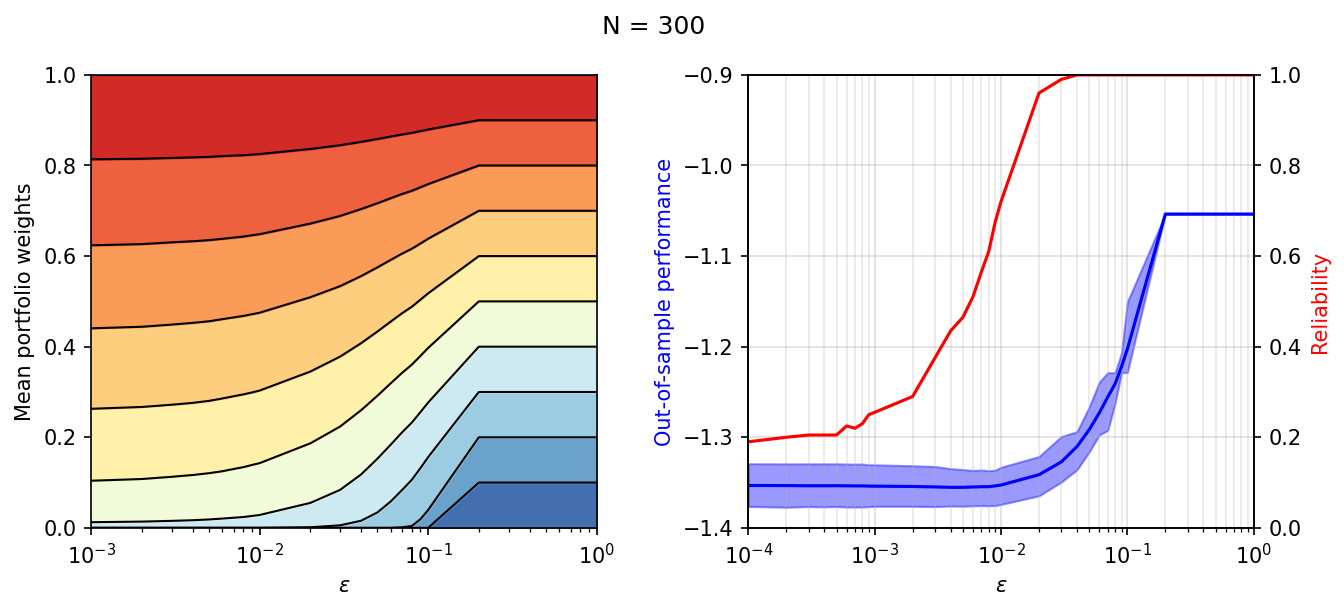

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=150, gridspec_kw={'wspace': 0.3})
fig.suptitle('N = {}'.format(N))

# Portfolio weight vs Wasserstein radius
for i in range(1, 11):
    ax[0].fill_between(epsilon_range, np.sum(sim1.weights[:, :i-1], axis=1), 
                       np.sum(sim1.weights[:, :i], axis=1),color=plt.cm.RdYlBu(1 - i/11))
    ax[0].plot(epsilon_range, np.sum(sim1.weights[:, :i], axis=1),
               color='black', linewidth=1.0)
ax[0].set_xscale('log')
ax[0].set_xlabel('$\epsilon$')
ax[0].set_xlim(10**-3, 1)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Mean portfolio weights')

# Evolution of certificate and reliability
ax[1].plot(epsilon_range, sim1.perf_mu, color='blue')
ax[1].fill_between(epsilon_range, sim1.perf_20, sim1.perf_80, color='blue', alpha=0.4)
ax[1].set_xscale('log')
ax[1].set_xlabel('$\epsilon$')
ax[1].set_xlim(10**-4, 1.0)
ax[1].set_ylabel('Out-of-sample performance', color='blue')
ax[1].set_yticks(np.arange(-1.4, -0.8, 0.1))
ax[1].grid(which='major',alpha=0.4)
ax[1].grid(which='minor',alpha=0.3)

ax2 = ax[1].twinx()

ax2.set_ylabel('Reliability', color='red')
ax2.plot(epsilon_range, sim1.reliability, color='red')
ax2.set_yticks(np.arange(0, 1.2, 0.2))
ax2.set_ylim(0, 1)

plt.savefig('sim1_N{}.jpg'.format(N), dpi = 150, bbox_inches='tight')
plt.show()
plt.show()

## Portfolios driven by out-of-sample performance

### Holdout method

In [7]:
class SimSet2_Holdout(DistributionallyRobustPortfolio):
    # Market setup
    m = 10

    # Radius range (see page 156 in Mohajerin Esfahani and Kuhn)
    eps_range = np.concatenate([np.arange(1, 10)*10.0**(i)
                                for i in range(-3, 0)])

    # Validation data set of 2*10**5 samples (page 158 in paper)
    valids = normal_returns(10, 2*10**5)

    def __init__(self, N, k=5):
        # 1/k sized split for the test data.
        self.k = k
        # Fusion model for (train) data size N*(k-1)/k (see holdout method)
        super().__init__(SimSet2_Holdout.m, np.rint(N*(k-1)/k).astype(np.int32))

    def validate(self, data_sets):
        '''
        Method to iterate over a list of independent datasets via the iter_data
        generator method so as to apply the holdout technique to each dataset 
        and then save the results.
        '''
        self.perf, self.cert, radii = zip(*self.iter_data(data_sets))
        self.rel = np.mean(np.array(self.perf) <= np.array(self.cert), axis=0)
        self.radius = np.mean(radii, axis=0)

    def simulate(self, data):
        '''
        Method called within the iter_data generator.

        Returns
        out_perf: out-of-sample performance calculated with validation data
        cert: performance certificate (optimal objective for M)
        eps_holdout: radius selected from holdout method
        '''
        # Split data into test and train
        train, self.test = train_test_split(data, test_size=1/self.k)
        # Set the TrainData parameter to train data
        self.dat.setValue(train)
        # Iterate through a range of Wasserstein radii
        out_perf_test, x, t, J_N = zip(
            *self.iter_radius(SimSet2_Holdout.eps_range))
        # Index of eps_holdout in the eps_range.
        min_arg = np.argmin(out_perf_test)
        # Out-of-sample performance for x_N(eps_holdout)
        out_perf = self.sample_average(
            x[min_arg], t[min_arg], SimSet2_Holdout.valids)
        # J_N(eps_holdout)
        cert = J_N[min_arg]
        return out_perf, cert, SimSet2_Holdout.eps_range[min_arg]

    def solve(self, epsilon):
        '''
        Method called within the iter_radius generator.

        Returns
        out_perf: SA-approx of out-of-sample performance using test data
        x: Portfolio weights
        t: Tau
        self.M.primalObjValue(): performance certificate
        '''
        # Set the WasRadius parameter
        self.eps.setValue(epsilon)
        # Solve the Fusion model
        self.M.solve()
        self.sol_time.append(self.M.getSolverDoubleInfo('optimizerTime'))
        # Weights and Tau optimal values
        x, t = self.x.level(), self.t.level()
        # SAA of out-of-sample performance based on test data
        out_perf = self.sample_average(x, t, self.test)
        return out_perf, x, t, self.M.primalObjValue()

In [8]:
# Range of cardinality values to consider
N_range = np.append(np.concatenate([np.arange(1,10)*10**(i) for i in range(1,3)]),1000)

holdout_results = []
for N in N_range:
    # List of 200 independent datasets of cardinality N
    n_data = [normal_returns(10, N) for i in range(200)]
    # Instance of SimSet2_Holdout class with cardinality N
    hld = SimSet2_Holdout(N)
    # Running the holdout method over each dataset
    hld.validate(n_data)
    # Save the object 
    holdout_results.append(hld)

In [9]:
def N_plot(results, title, save_name, y_l = [[-1.5, 0.5], [-2.5, 10], [0, 1]]):
    N_range = np.append(np.concatenate(
        [np.arange(1, 10)*10**(i) for i in range(1, 3)]), 1000)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 3), dpi=150)
    fig.suptitle(title)
    # Out-of-sample performance
    ax[0].fill_between(N_range, [np.quantile(r.perf, 0.2, axis=0) for r in results], [
                       np.quantile(r.perf, 0.8, axis=0) for r in results], alpha=0.4)
    ax[0].plot(N_range, [np.mean(r.perf, axis=0) for r in results], marker='>')
    # Certificate
    ax[1].fill_between(N_range, [np.quantile(r.cert, 0.2, axis=0) for r in results], [
                       np.quantile(r.cert, 0.8, axis=0) for r in results], alpha=0.4)
    ax[1].plot(N_range, [np.mean(r.cert, axis=0) for r in results], marker='>')
    # Reliability
    ax[2].plot(N_range, [r.rel for r in results], marker='>')

    y_n = ["Out-of-sample performance", "Certificate", "Reliability"]
    for i in range(3):
        ax[i].set_ylabel(y_n[i])
        ax[i].set_ylim(y_l[i])
        ax[i].grid(which='major',alpha=0.4)
        ax[i].grid(which='minor',alpha=0.3)
        ax[i].set_xscale('log')
        ax[i].set_xlabel('N')
        ax[i].set_xlim([10, 1000])
    ax[0].set_yticks([-1.5, -1, -0.5, 0, 0.5])
    plt.savefig(save_name, dpi = 150, bbox_inches='tight')
    plt.show()

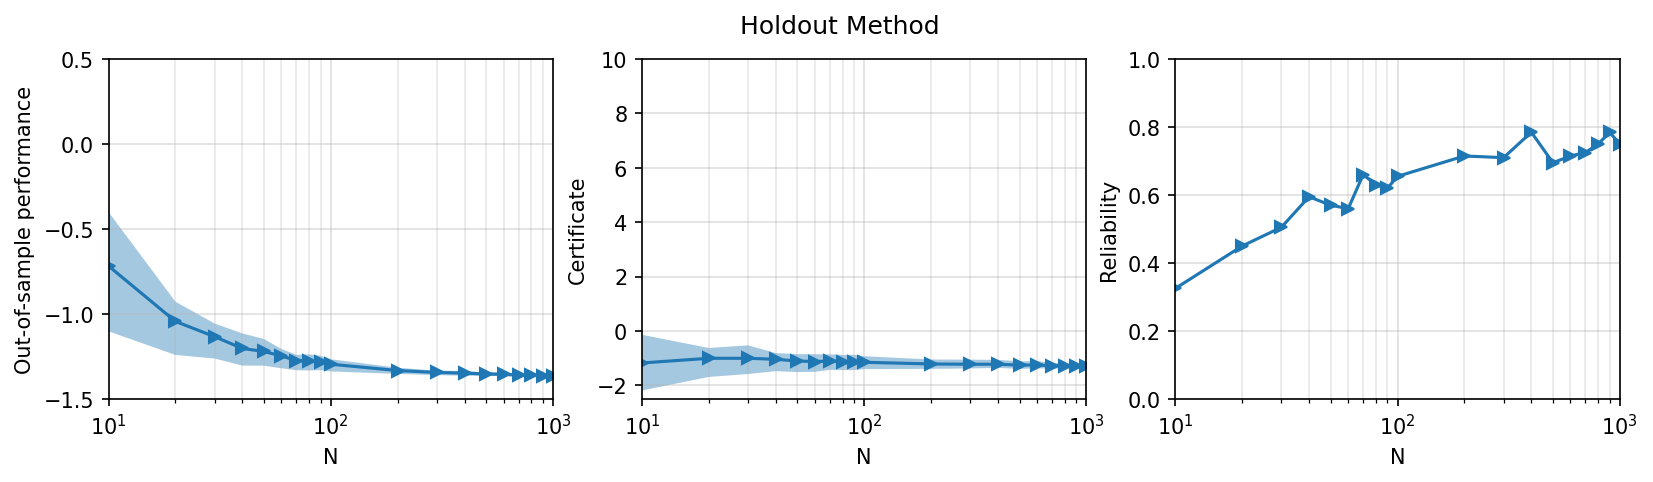

In [10]:
N_plot(holdout_results, 'Holdout Method', 'sim2_holdout.jpg')

### k-fold cross validation method

In [11]:
# IMPORTANT: sub-class of the SimSet2_Holdout class!
class SimSet2_kFold(SimSet2_Holdout):

    def __init__(self, N, k=5):
        self.k = k
        # Object for holdout method (k-holdouts)
        super().__init__(N, k=k)
        # Fusion model for N-size dataset (results)
        self.M_N = self.portfolio_model(SimSet2_Holdout.m, N)
        self.dat_N = self.M_N.getParameter('TrainData')
        self.eps_N = self.M_N.getParameter('WasRadius')
        self.x_N = self.M_N.getVariable('Weights')
        self.t_N = self.M_N.getVariable('Tau')

    def simulate(self, data):
        '''
        Method called within the iter_data generator. This method overwrites
        the one defined in the SimSet2_Holdout class.

        Returns
        out_perf: out-of-sample performance calculated with validation data
        cert: performance certificate (optimal objective for M_N)
        eps_kFold: radius selected from k-Fold method
        '''
        # Set TrainData paremeter for M_N to data
        self.dat_N.setValue(data)
        # Perform the holdout method k times and calculate eps_kFold
        eps_kFold = np.mean([self._simulate(data) for i in range(self.k)])
        # Set WasRadius to mean from k holdout runs
        self.eps_N.setValue(eps_kFold)
        # Solve the M_N model.
        self.M_N.solve()
        # Out-of-sample performance for x_N(eps_kFold)
        out_perf = self.sample_average(
            self.x_N.level(), self.t_N.level(), SimSet2_Holdout.valids)
        # J_N(eps_kFold)
        cert = self.M_N.primalObjValue()
        return out_perf, cert, eps_kFold

    def _simulate(self, data):
        '''
        Method to perform the holdout technique for a given dataset. This 
        is called k times within each call to the simulate method. Works
        analogously to the simulate method of SimSet2_Holdout class.

        Returns:
        eps_holdout: WasRadius selected in one holdout run
        '''
        # Split data into test and train
        train, self.test = train_test_split(data, test_size=1/self.k)
        # Set TrainData parameter for the N*(k-1)/k model
        self.dat.setValue(train)
        # Solve N*(k-1)/k model iteratively for a range of radii
        saa, x, t, J_N = zip(*self.iter_radius(SimSet2_Holdout.eps_range))
        # Select Wasserstein radius that minimizes out-of-sample perf
        min_arg = np.argmin(saa)
        return SimSet2_Holdout.eps_range[min_arg]

In [12]:
# Range of cardinality values to consider
N_range = np.append(np.concatenate([np.arange(1,10)*10**(i) for i in range(1,3)]),1000)

kFold_results = []

for N in N_range:
    # List of 200 independent datdasets of cardinality N
    n_data = [normal_returns(10,N) for i in range(200)]
    # Instance of SimSet2_kFold class with cardinality N
    kFld = SimSet2_kFold(N)
    # Running the k-fold cross validation over each dataset
    kFld.validate(n_data)
    kFold_results.append(kFld)

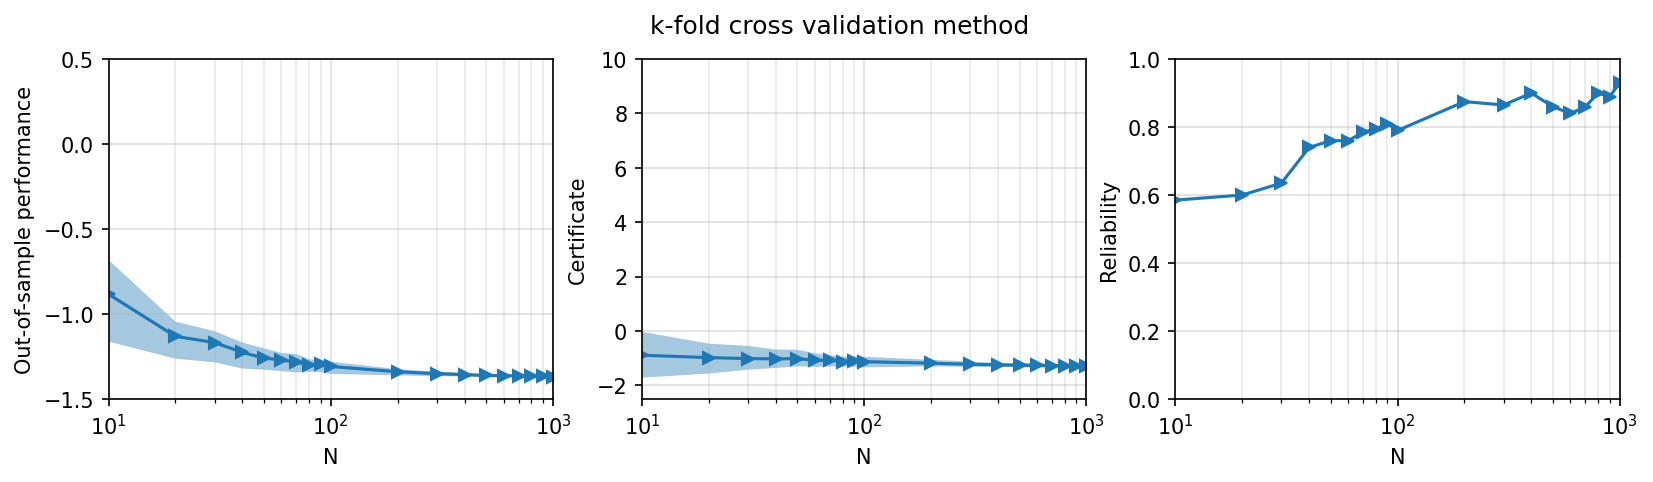

In [22]:
N_plot(kFold_results, 'k-fold cross validation method', 'sim2_kcross.jpg')

## Portfolios driven by reliability

In [17]:
class SimSet3(DistributionallyRobustPortfolio):
    m = 10
    eps_range = np.concatenate([np.arange(1, 10)*10.0**(i)
                                for i in range(-3, 0)])
    valids = normal_returns(10, 2*10**5)

    def __init__(self, beta, N, k=50):
        # Number of resamples
        self.k = k
        # Reliability threshold
        self.beta = beta
        # Instantiate Fusion model
        super().__init__(SimSet3.m, N)

    def bootstrap(self, data_sets):
        '''
        Method to iterate over a list of independent datasets via the iter_data
        generator method so as to apply the bootstrap technique to each dataset
        and then save the results.
        '''
        self.perf, self.cert, radii = zip(*self.iter_data(data_sets))
        self.rel = np.mean(np.array(self.perf) <= np.array(self.cert), axis=0)
        self.radii = np.mean(radii, axis=0)

    def simulate(self, data):
        '''
        Method called within the iter_data generator.

        Returns
        out_perf: out-of-sample performance calculated with validation data
        cert: performance certificate (optimal objective for M)
        eps_btstrp: radius selected from holdout method
        '''
        # List to store reliability
        rel = []
        # Perform k resamples
        for i in range(self.k):
            # Split data into test and train
            train, self.test = train_test_split(data, test_size=1/3)
            # Resample train data up-to size N
            train = resample(train, n_samples=self.N)
            # Set TrainData parameter to train
            self.dat.setValue(train)
            # Iterate through a range of Wasserstein radii
            rel.append(list(self.iter_radius(SimSet3.eps_range)))
        # Sum reliability over all resamples (for each epsilon)
        rel = np.sum(rel, axis=0)
        # Smallest radius that has reliability over 1-beta
        _id = next(i for i, r in enumerate(rel) if r >= self.k*(1-self.beta))
        eps_btstrp = SimSet3.eps_range[_id]
        # Set TrainData parameter to data
        self.dat.setValue(data)
        # Set WasRadius parameter to eps_btstrp
        self.eps.setValue(eps_btstrp)
        self.M.solve()
        # Out-of-sample performance for x_N(eps_btstrp)
        out_perf = self.sample_average(
            self.x.level(), self.t.level(), SimSet3.valids)
        cert = self.M.primalObjValue()
        return out_perf, cert, eps_btstrp

    def solve(self, epsilon):
        '''
        Method called within the iter_radius generator.

        Returns
        reliability: SAA of out-of-sample performance <= certificate(epsilon)
        '''
        # Set WasRadius parameter to epsilon and solve
        self.eps.setValue(epsilon)
        self.M.solve()
        # Calculate out-of-sample performance SAA estimator using test
        saa = self.sample_average(self.x.level(), self.t.level(), self.test)
        # Boolean to state if the certificate is greater than SAA estimate
        return saa <= self.M.primalObjValue()

In [18]:
# Range of cardinality values to consider
N_range = np.append(np.concatenate(
        [np.arange(1, 10)*10**(i) for i in range(1, 3)]), 1000)
# Reliability threshold: 1 - beta = 0.9
beta = 0.1

bootstrap_results = []
for N in N_range:
    n_data = [normal_returns(10,N) for i in range(200)]
    # Instance of SimSet3 class with cardinality N
    btstrp = SimSet3(beta,N)
    # Running the bootstrap method for each dataset
    btstrp.bootstrap(n_data)
    bootstrap_results.append(btstrp)  

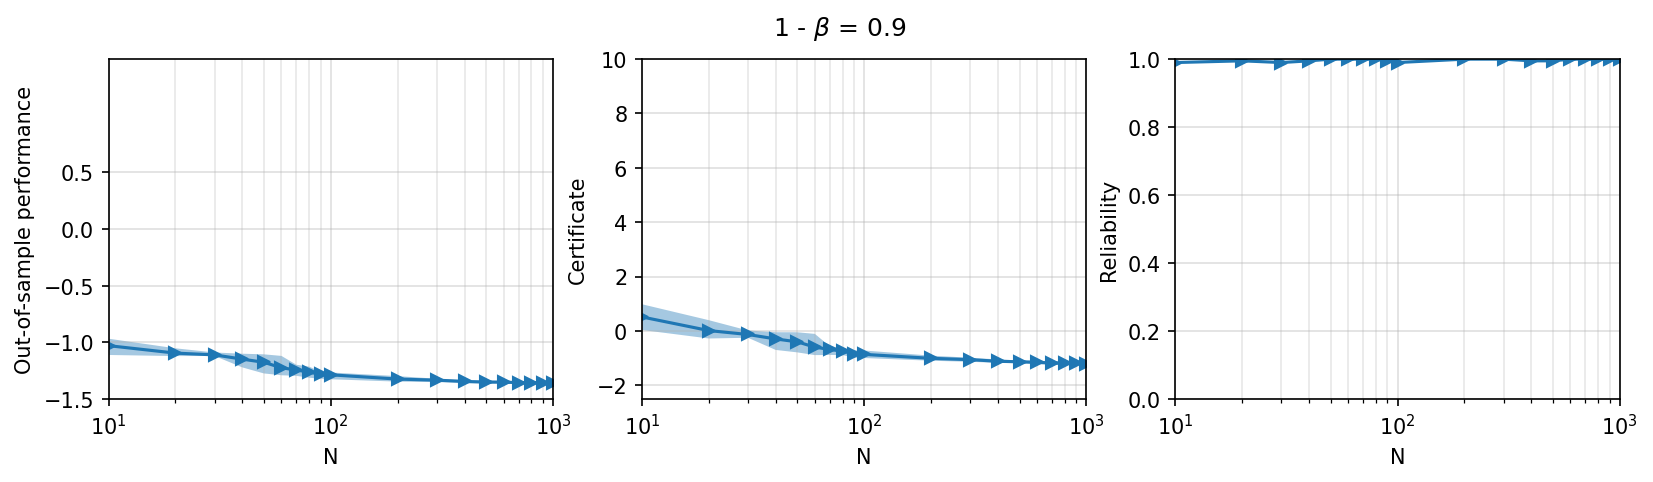

In [21]:
N_plot(bootstrap_results, "1 - $\\beta$ = {}".format(1-beta), 'sim3_90.jpg',
       y_l = [[-1.5, 1.5], [-2.5, 10], [0, 1]])

## Impact of sample size on Wasserstein radius

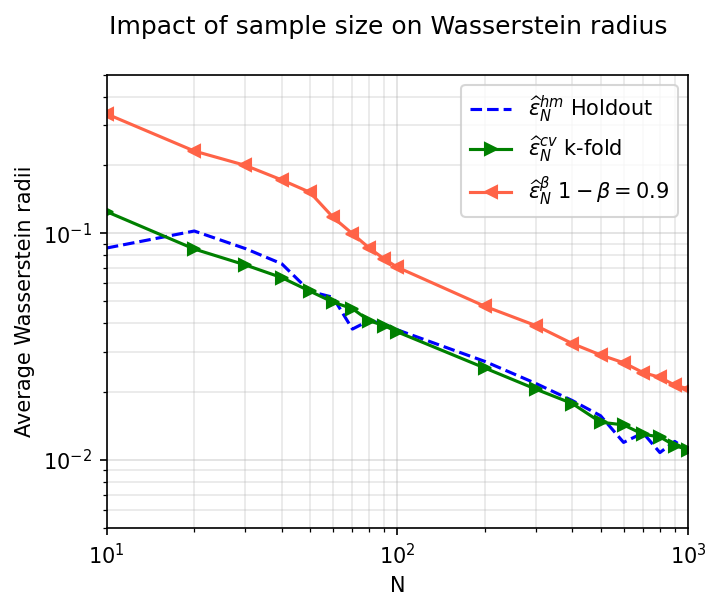

In [44]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
fig.suptitle('Impact of sample size on Wasserstein radius')

# Wasserstein radius vs sample size N
# HoldouN_rangeethod
ax.plot(N_range, [h.radius for h in holdout_results], color='blue',
        linestyle='--', label='$\widehat{\epsilon}^{hm}_N$ Holdout')
# k-fold cross validation method
ax.plot(N_range, [k.radius for k in kFold_results], color='green', 
        marker='>', label='$\widehat{\epsilon}^{cv}_N$ k-fold')
# Bootstrap method (reliability driven portfolio)
ax.plot(N_range, [b.radii for b in bootstrap_results], color='tomato', 
        marker='<', label=r'$\widehat{\epsilon}^{\beta}_N$ $1 - \beta = 0.9$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('N')
ax.set_xlim(10, 1000)
ax.set_ylim(0.005, 0.5)
ax.set_ylabel('Average Wasserstein radii')
ax.grid(which='major',alpha=0.4)
ax.grid(which='minor',alpha=0.3)
ax.legend()
plt.savefig('radius_v_samplesize.jpg', dpi = 150, bbox_inches='tight')
plt.show()

The results provided in this notebook were computed on a laptop with Intel® Core™ i7-10875H processor and 32 GB RAM.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 